In [2]:
import numpy as np
import uproot
import aiohttp
from matplotlib import pyplot as plt
import awkward as ak
from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [3]:
stuff = np.random.normal( loc=[1.1, 1.8], scale=[0.8,0.5], size=(100000, 2) )

In [4]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print(tf.config.list_physical_devices('GPU'))

['/device:CPU:0']
[]


In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

[]


(100000, 2)


(array([[0.0000e+00, 0.0000e+00, 5.0000e+00, 1.5000e+01, 2.4000e+01,
         1.4000e+01, 8.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 5.0000e+00, 5.3000e+01, 2.3600e+02, 4.0600e+02,
         3.5300e+02, 1.3000e+02, 1.9000e+01, 1.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.9000e+01, 4.4900e+02, 1.5510e+03, 2.8550e+03,
         2.3910e+03, 8.8200e+02, 1.5600e+02, 1.0000e+01, 0.0000e+00],
        [1.1000e+01, 1.5200e+02, 1.2650e+03, 4.9040e+03, 8.9670e+03,
         7.2820e+03, 2.8860e+03, 4.9200e+02, 3.6000e+01, 0.0000e+00],
        [1.3000e+01, 2.0600e+02, 1.6490e+03, 6.7560e+03, 1.2172e+04,
         1.0080e+04, 3.8020e+03, 6.3400e+02, 4.4000e+01, 3.0000e+00],
        [1.0000e+01, 1.3500e+02, 1.0380e+03, 4.1120e+03, 7.4940e+03,
         6.2250e+03, 2.4230e+03, 4.3000e+02, 3.8000e+01, 2.0000e+00],
        [2.0000e+00, 2.5000e+01, 2.9600e+02, 1.1780e+03, 2.1420e+03,
         1.8320e+03, 6.8500e+02, 1.1900e+02, 1.1000e+01, 0.0000e+00],
        [0.0000e+00, 1.0000

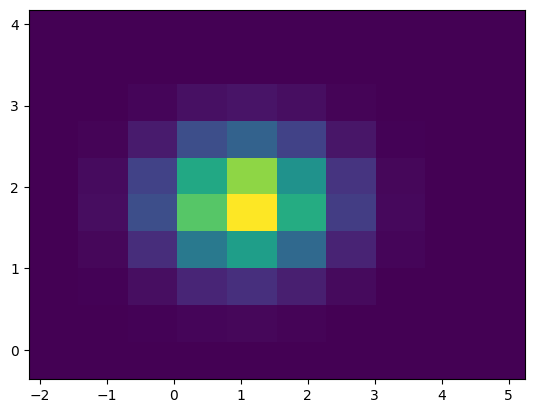

In [6]:
print(stuff.shape)
plt.hist2d( stuff[:,0], stuff[:,1] )

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_virtual_device_configuration(
#    gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[]


In [8]:
def synthroot(filename, data, data2):
    with uproot.recreate(filename) as file:
        file["testree"] = {"theta0": data, "theta_unknown_S": data2}
        file["twotree"] = {"theta0Z": data, "thetaUS": data2}


In [9]:
events = uproot.open("QCD_pt.root:Events")
#print(events.keys())

qcd_mc = uproot.open('QCD_pt.root')
uprootevents = qcd_mc['Events']
#print(uprootevents.keys())
#print(events.keys('FatJet*'))

#fatjet_pt = uprootevents['FatJet_pt'].array()
#print(ak.num(fatjet_pt))
#Ev = events[ak.num(events['FatJet_pt'].array())>0]
#print(Ev)



fk8 = events['GenJetAK8_pt'].array() # array of all 0s in Genjet
tk8 = ak.num(fk8) > 0
print('tk8')
print(tk8)
#print(fpt[tpt])


fpt = events['FatJet_pt'].array() # Fat jet with all genjet 0s removed 
tes = fpt[tk8]
print('tes')
print(tes)

tpt = ak.num(tes) > 0  # Fat jet with both Fat 0s and Gen 0s removed
print('tpt')
print(tpt)
print(tes[tpt])


testquants = ['FatJet_pt','FatJet_mass','FatJet_phi', 'FatJet_eta','GenJetAK8_eta','GenJetAK8_phi','GenJetAK8_pt','GenJetAK8_mass']
quantvals = []

for quantity in range(len(testquants)):
    print(testquants[quantity])
    print(testquants[-(1+quantity)])
    fk8 = events[testquants[-(1+quantity)]].array() # array of all 0s in secondary jet
    tk8 = ak.num(fk8) > 0
    #print('tk8')
    #print(tk8)
    #print(fpt[tpt])
    
    
    fpt = events[testquants[quantity]].array() # output jet with all secondary jet 0s removed 
    tes = fpt[tk8]
    #print('tes')
    #print(tes)
    
    tpt = ak.num(tes) > 0  # primary jet with both its own 0s and secondary jet 0s removed
    #print('tpt')
    #print(tpt)
    #print(tes[tpt][:,:1])
    quantvals.append(tes[tpt][:,:1])
    

print("LOOP DONE")
#print(uprootevents.keys('FatJet*'))
#### getting leading jet pt and mass as storing as numpy-like array
jetr = tes[tpt][:,:1]

jet_recopt = quantvals[0]
jet_recomass = quantvals[1]
jet_recophi = quantvals[2]
jet_recoeta = quantvals[3]
jet_geneta = quantvals[-4]
jet_genphi = quantvals[-3]
jet_genpt = quantvals[-2]
jet_genmass = quantvals[-1]


#jet_recopt = events['FatJet_pt'].array()[:,:1]
#jet_recomass = uprootevents['FatJet_mass'].array()[:,:1]
#jet_genpt = uprootevents['GenJetAK8_pt'].array()[:,:1]
#jet_genmass = uprootevents['GenJetAK8_mass'].array()[:,:1]
print(jet_recopt)
#print(jetr)


#Events = events[ak.num(events['FatJet_pt'].array()) > 0]
#Events = events[ak.num(events.keys('FatJet*')) > 0]

tk8
[True, True, False, True, False, False, ... True, True, True, True, True, True]
tes
[[], [], [392, 363], [], ... 242], [6.18e+03, 6.18e+03], [2.86e+03, 2.42e+03]]
tpt
[False, False, True, False, True, True, True, ... True, True, True, True, True, True]
[[392, 363], [189], [1.45e+03, ... [6.18e+03, 6.18e+03], [2.86e+03, 2.42e+03]]
FatJet_pt
GenJetAK8_mass
FatJet_mass
GenJetAK8_pt
FatJet_phi
GenJetAK8_phi
FatJet_eta
GenJetAK8_eta
GenJetAK8_eta
FatJet_eta
GenJetAK8_phi
FatJet_phi
GenJetAK8_pt
FatJet_mass
GenJetAK8_mass
FatJet_pt
LOOP DONE
[[392], [189], [1.45e+03], [778], ... [668], [2.34e+03], [6.18e+03], [2.86e+03]]


In [10]:
amt = len(jet_genmass)//2

In [11]:
#jet_recopt = quantvals[0]
#jet_recomass = quantvals[1]
#jet_genpt = quantvals[]
#jet_genmass = quantvals[3]

amt = len(jet_genmass)//2
print(amt)

150396


In [12]:
# Pretend MC Fat
# Pretend Data Gen
# Pt, Mass are 2D
# Stack both

# Split in half to have testing
#genjet are MC, True, FatJet be reco
#genjet theta G, fatjet, theta S
print(amt)
theta0_G = np.column_stack((
    jet_genmass[:amt],   # 1 dee
    jet_genpt[:amt]    # 2 dee
))

theta0_S = np.column_stack((
    jet_recomass[:amt],   # 1 dee
    jet_recopt[:amt]    # 2 dee
))


# Natural
theta_unknown_G = np.column_stack([
    jet_genmass[amt:],   # 1 dee
    jet_genpt[amt:]    # 2 dee
])

theta_unknown_S = np.column_stack([
    jet_recomass[amt:],   # 1 dee
    jet_recopt[amt:]    # 2 dee
])

theta0 = np.stack((theta0_G, theta0_S), axis=1)

print(theta0_G)
print(theta_unknown_G)
print(theta0)

150396
[[61.2, 379], [36.6, 187], [46.5, ... 1.48e+03], [76.8, 843], [276, 2.56e+03]]
[[258, 2.08e+03], [138, 702], [53.7, ... 2.3e+03], [398, 5.96e+03], [148, 2.91e+03]]
[[[61.2, 379], [59.6, 392]], [[36.6, ... 921]], [[276, 2.56e+03], [271, 2.63e+03]]]


In [13]:
#print("Shape theta0_G:", theta0_G.shape)
#print("Shape 0_S:", theta0_S.shape)
#print("Shape theta0:", theta0t.shape)
#print("Shape unknown s:", theta_unknown_St.shape)
#print("Shape theta0 Tree:", events["theta0"].array(library="np").shape)
#print("Shape unknown s Tree:", events["theta_unknown_S"].array(library="np").shape)

#theta0 = events["theta0"].array(library="np")
#theta_unknown_S = events["theta_unknown_S"].array(library="np")

(array([0.0000e+00, 7.0000e+00, 5.3390e+03, 1.2124e+04, 9.2000e+03,
        7.3020e+03, 6.1350e+03, 5.2290e+03, 4.7240e+03, 4.1370e+03,
        3.8220e+03, 3.4950e+03, 3.1990e+03, 3.1540e+03, 2.7660e+03,
        2.6220e+03, 2.4570e+03, 2.4050e+03, 2.2540e+03, 2.1610e+03,
        2.1110e+03, 1.9960e+03, 1.9260e+03, 1.9020e+03, 1.8450e+03,
        1.6860e+03, 1.7000e+03, 1.6070e+03, 1.5930e+03, 1.5430e+03,
        1.4630e+03, 1.4810e+03, 1.3870e+03, 1.3980e+03, 1.3390e+03,
        1.3510e+03, 1.2780e+03, 1.3050e+03, 1.2390e+03, 1.2100e+03,
        1.1860e+03, 1.2280e+03, 1.1070e+03, 1.1420e+03, 1.1300e+03,
        1.0300e+03, 1.0120e+03, 9.7100e+02, 9.1300e+02, 9.3300e+02,
        8.8600e+02, 8.8400e+02, 8.6000e+02, 8.1400e+02, 8.3300e+02,
        7.5700e+02, 7.8400e+02, 7.4600e+02, 6.9600e+02, 7.3200e+02,
        6.0800e+02, 6.1000e+02, 6.5300e+02, 5.9800e+02, 6.3500e+02,
        5.5700e+02, 5.9300e+02, 5.5200e+02, 5.5700e+02, 5.3700e+02,
        5.3800e+02, 5.1500e+02, 4.5200e+02, 4.80

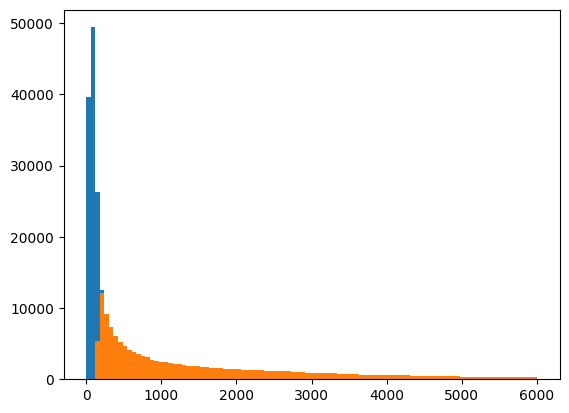

In [14]:
plt.hist( theta0_G[:,0], bins=np.linspace(0,6000, 100) )
plt.hist( theta0_G[:,1], bins=np.linspace(0,6000, 100) )

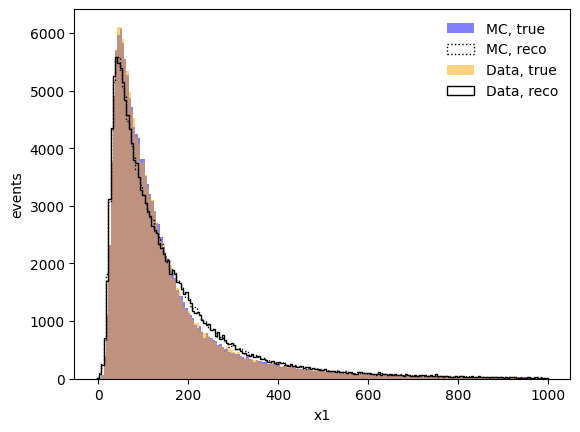

In [15]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S[:,0],bins=np.linspace(-3,1000,200),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S[:,0],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Data, reco")
plt.xlabel("x1")
plt.ylabel("events")
plt.legend(frameon=False)


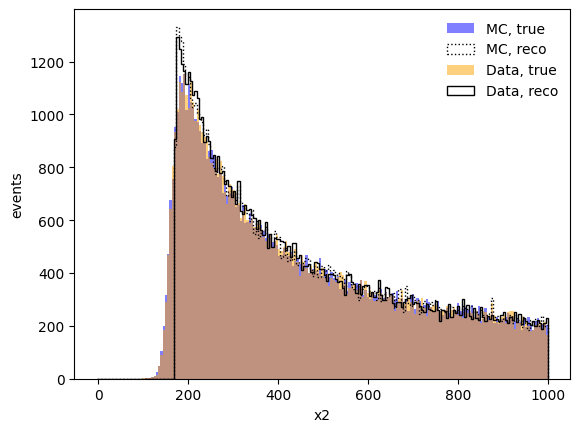

In [16]:
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S[:,1],bins=np.linspace(-3,1000,200),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:, 1],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S[:, 1],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Data, reco")
plt.xlabel("x2")
plt.ylabel("events")
plt.legend(frameon=False)


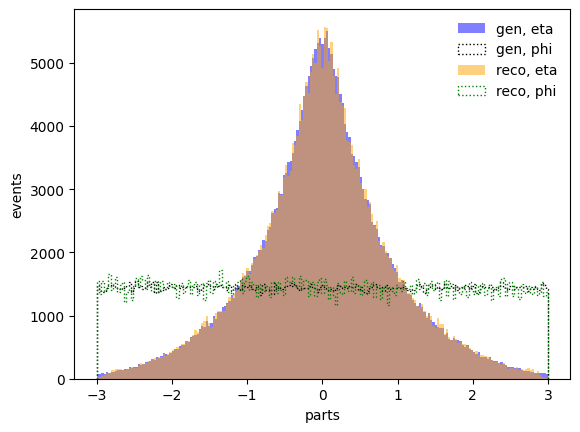

In [17]:
_,_,_=plt.hist(jet_geneta[:],bins=np.linspace(-3,3,200),color='blue',alpha=0.5,label="gen, eta")
_,_,_=plt.hist(jet_genphi[:],bins=np.linspace(-3,3,200),histtype="step",color='black',ls=':',label="gen, phi")
_,_,_=plt.hist(jet_recoeta[:],bins=np.linspace(-3,3,200),color='orange',alpha=0.5,label="reco, eta")
_,_,_=plt.hist(jet_recophi[:],bins=np.linspace(-3,3,200),histtype="step",color='green',ls=':',label="reco, phi")
#_,_,_=plt.hist(jet_genmass[:],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Data, true")
#_,_,_=plt.hist(jet_genpt[:],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Data, reco")
plt.xlabel("parts")
plt.ylabel("events")
plt.legend(frameon=False)

In [18]:
# # test 4d
# np.random.seed(42)
# a = np.random.randint(0, 5, 100)
# b = np.random.randint(0, 5, 100)
# c = np.random.rand(100)
# d = np.random.rand(100)

# fig, axs = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10, 10))

# for i in range(5):
#     for j in range(5):
#         #filter
#         mask = (a == i) & (b == j)
#         current_c = c[mask]
#         current_d = d[mask]

#         #scatter in sub
#         axs[i, j].scatter(current_c, current_d, s=10)

#         #labels
#         axs[i, j].set_xlabel('c')
#         axs[i, j].set_ylabel('d')

#         #title
#         axs[i, j].set_title(f'a={i}, b={j}')

# plt.tight_layout()
# plt.show()


TypeError: to_rectilinear argument must be iterable

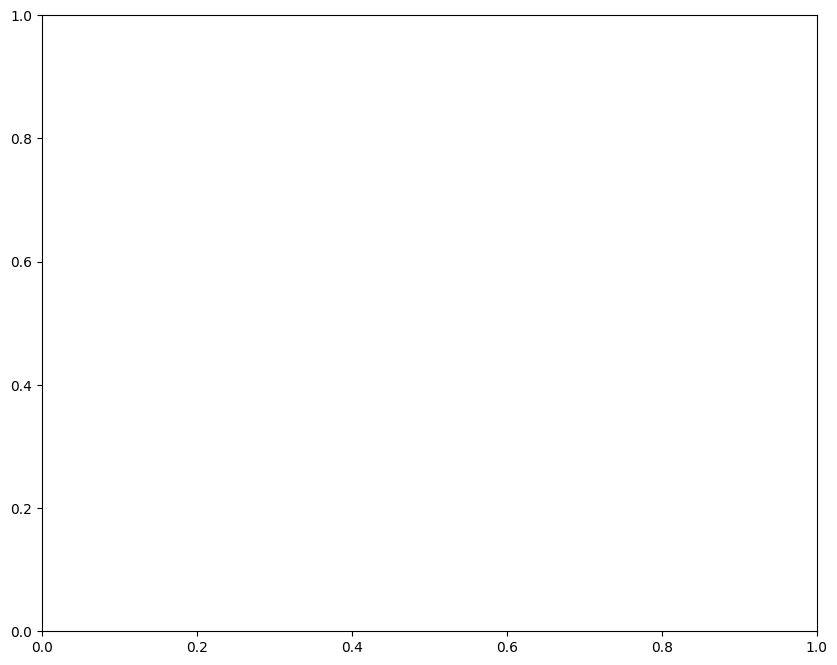

In [19]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(theta_unknown_S[:, 0], theta_unknown_S[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Hist: Data, true")
plt.show()

In [20]:
# #Data, true
# theshape=theta_unknown_S.shape
# print(theshape)
# N = theshape[0] * theshape[1]
# plt.figure(figsize=(10, 8))
# plt.hist(theta_unknown_S.reshape(N), cmap='Oranges', alpha=0.5, label="Data, true")
# plt.show()

In [21]:
# _, _, _ = plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), cmap='Blues', alpha=0.5, label="MC, true")
# _, _, _ = plt.hist2d(theta_unknown_G[:, 0], theta_unknown_G[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
# _, _, _ = plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), weights=myweights[-1, 0, :], cmap='Greys', alpha=0.5, label="OmniFolded")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend(frameon=False)
# plt.show()


In [22]:
inputs = Input((2,))  # 2D input
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [24]:
myweights = of.omnifold(ak.to_numpy(theta0),ak.to_numpy(theta_unknown_S),20,model)

theta0G (150396, 2), labels (150396,), labels unknown (150396,), theta 0(150396, 2, 2), theta unknown s(150396, 2)
16/16 [==============================] - 0s 4ms/step


In [31]:
# #needless
# plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), cmap='Blues', alpha=0.5, label="MC, true")
# plt.hist2d(theta_unknown_G[:, 0], theta_unknown_G[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
# plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), weights=myweights[-1, 0, :], cmap='Greys', alpha=0.5, label="OmniFolded")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend(frameon=False)
# plt.show()

In [31]:
print("Shape theta0_G:", theta0_G.shape)
print("Shape weights:", myweights.shape)


AttributeError: no field named 'shape'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.5/src/awkward/highlevel.py#L1124)

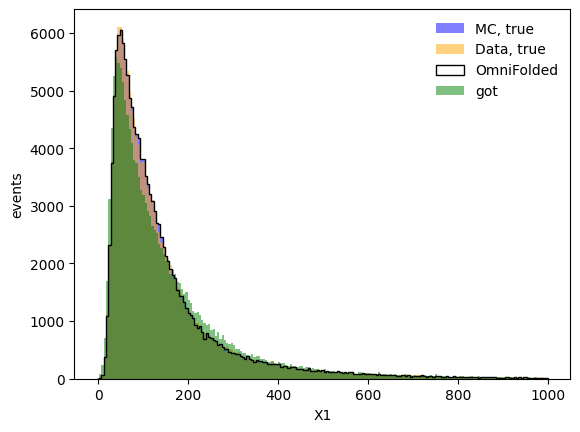

In [37]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,1000,200),color=['orange'],alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
_,_,_=plt.hist(theta_unknown_S[:,0],bins=np.linspace(-3,1000,200),color=['green'],alpha=0.5,label="got")
plt.xlabel("X1")
plt.ylabel("events")
plt.legend(frameon=False)

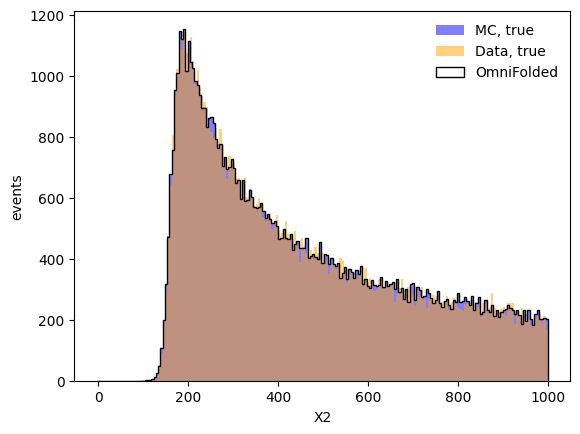

In [34]:
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,1000,200),color=['blue'],alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G[:,1],bins=np.linspace(-3,1000,200),color=['orange'],alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("X2")
plt.ylabel("events")
plt.legend(frameon=False)

In [21]:
# Draw the response matrix    
# plt.figure(1)
# G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,0],theta_unknown_G[:,0], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
# plt.xlabel('True')
# plt.ylabel('Reco')
# plt.colorbar()

In [22]:
# Draw the response matrix    
# plt.figure(1)
# G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,1],theta_unknown_G[:,1], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
# plt.xlabel('True')
# plt.ylabel('Reco')
# plt.colorbar()